# Climate Hack.AI 2022 DATA EXPLORATION

## Prerequisites

* `xarray` for representing n-dimensional labelled arrays
* `zarr` for loading the Zarr dataset
* `gcsfs` for loading from Google Cloud Storage:  used implicitly by xarray)
* `dask` used under the hood by xarray to enable parallel processing of datasets too large to fit into RAM
* `torch` (PyTorch) for training a model
* `pytorch_msssim` to use a multi-scale structural similarity index measure-based loss function
* `matplotlib` for plotting

## Importing modules

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
from numpy import float32
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd
from dataset import ClimateHackDataset
from loss import MS_SSIMLoss
from submission.model import Model
import albumentations as A

plt.rcParams["figure.figsize"] = (20, 12)
torch.rand(0).to(torch.device('cuda'))

tensor([], device='cuda:0')

In [2]:
df = pd.read_csv('./cleaned_data/meta_data.csv')
a = df[df.valid_start].iloc[0].idx
b = a + 11
df.iloc[a].date_column.replace('-','_')+'.npy'

'2020_01_01.npy'

(12, 891, 1843) (24, 891, 1843)


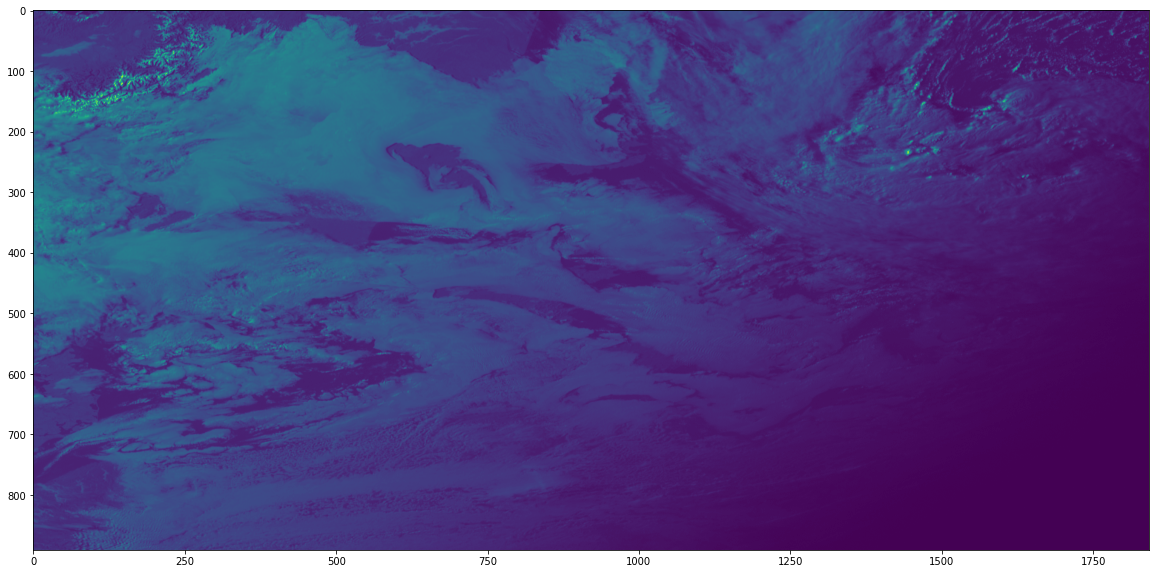

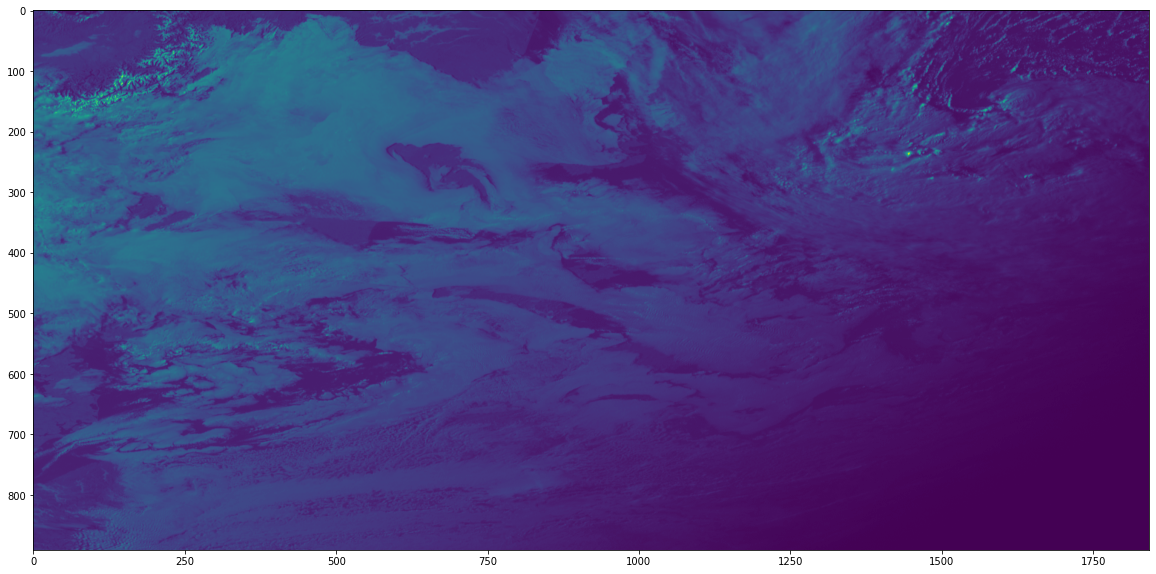

In [3]:
# Test my data class
for image, target in ClimateHackDataset(split='val', transform=None, target_transform=None):
    print(image.shape, target.shape)
    plt.imshow(image[-1])
    plt.show()
    plt.imshow(target[0])
    plt.show()
    break

## Loading the dataset

The 108GB HRV ("high resolution visible") satellite imagery dataset may be loaded directly from Google Cloud Public Datasets using `xarray`, `zarr`, `gcsfs` and `dask`. Alternatively a local copy can be downloaded and loaded instead for better performance. The pixel values represent calibrated top-of-atmosphere bidirectional irradiance values mapped to the range `[0, 1023]`. Read more about the data on the [Google Cloud Platform](https://console.cloud.google.com/marketplace/product/bigquery-public-data/eumetsat-seviri-rss-hrv-uk).

### Loading the dataset from the cloud

In [3]:
SATELLITE_ZARR_PATH = "eumetsat_seviri_hrv_uk.zarr"

dataset = xr.open_dataset(
    SATELLITE_ZARR_PATH, 
    engine="zarr",
    chunks="auto",  # Load the data as a Dask array
)

dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(22, 891, 1843), meta=np.ndarray>

## Visualising the data

You may be curious what these 1841x891 "high resolution visible" satellite images actually look like! 

Here is an example:

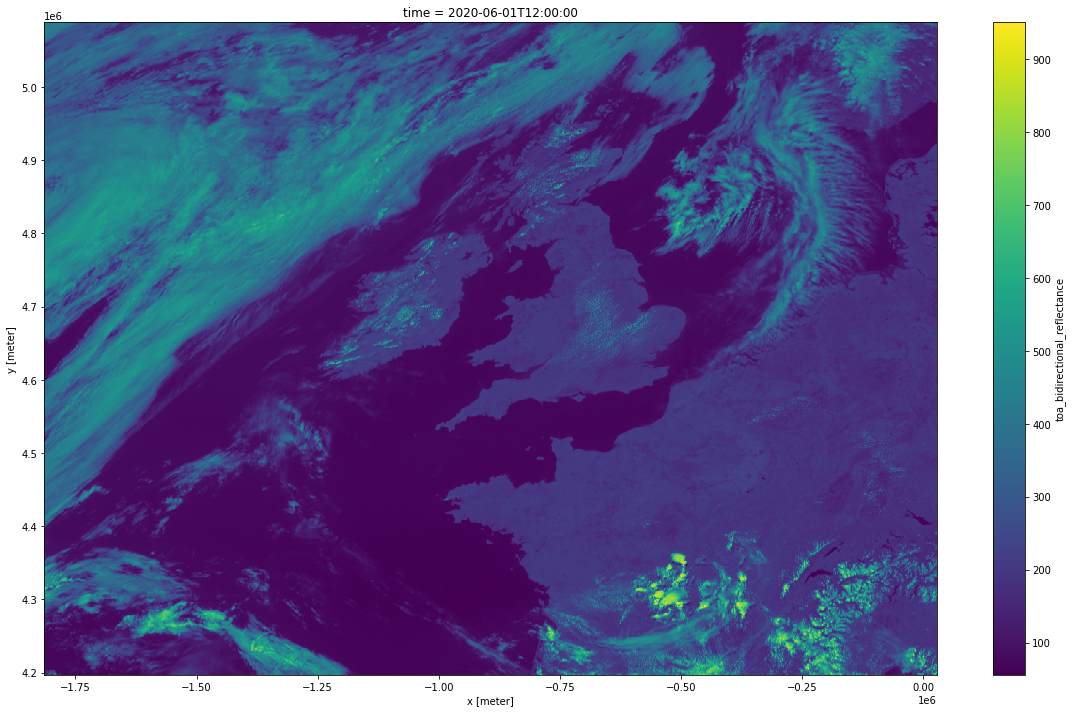

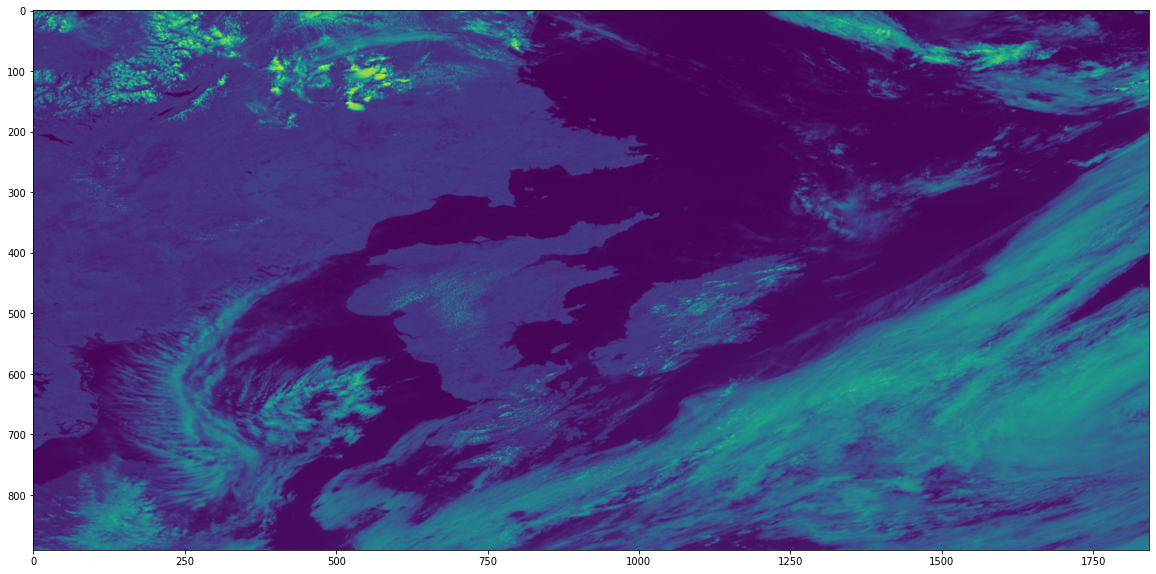

(891, 1843)


In [4]:
dataset["data"].sel(time="2020-06-01 12:00").plot()
plt.show()

img = dataset["data"].sel(time="2020-06-01 12:00")
plt.imshow(img)
plt.show()
print(img.shape)

DatetimeIndex(['2020-01-01 00:05:00', '2020-01-01 00:10:00',
               '2020-01-01 00:15:00', '2020-01-01 00:20:00',
               '2020-01-01 00:25:00', '2020-01-01 00:30:00',
               '2020-01-01 00:35:00', '2020-01-01 00:40:00',
               '2020-01-01 00:45:00', '2020-01-01 00:50:00',
               ...
               '2021-11-07 15:05:00', '2021-11-07 15:10:00',
               '2021-11-07 15:15:00', '2021-11-07 15:20:00',
               '2021-11-07 15:25:00', '2021-11-07 15:30:00',
               '2021-11-07 15:35:00', '2021-11-07 15:40:00',
               '2021-11-07 15:45:00', '2021-11-07 15:50:00'],
              dtype='datetime64[ns]', name='time', length=173624, freq=None)
(array([104664]),)


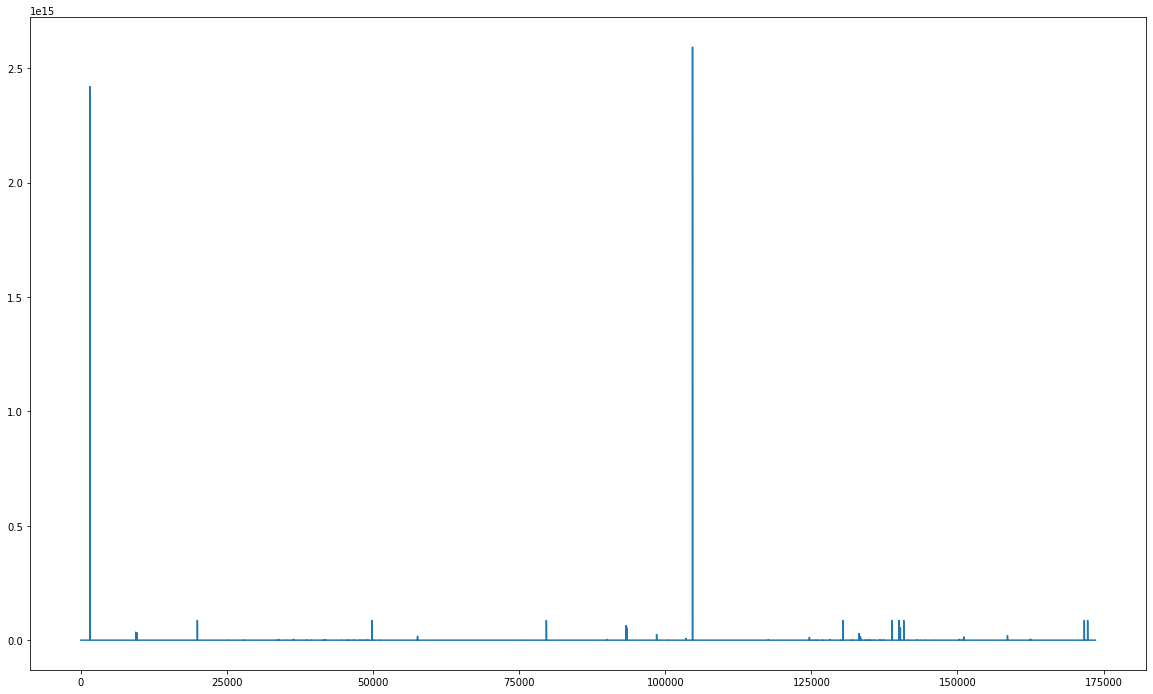

In [5]:
times = dataset.get_index("time")
print(times)
dt = times[1:].astype(np.int32)-times[:-1].astype(np.int32)


plt.plot(dt)
print(np.where(dt==dt.max()))
plt.show()


In [6]:
df = pd.DataFrame({'time':times})
df.time = pd.to_datetime(df.time)

# Need to also consider time of day! Naive 0800-1700 Should probably use pvlib to calculate when the time of days are which have day light, see below.
#pvlib.solarposition.sun_rise_set_transit_spa(times, latitude, longitude, how='numpy', delta_t=67.0, numthreads=4)
#https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.solarposition.sun_rise_set_transit_spa.html
#df.index

#How do I select only times that are after 8am?


# Found and tagged all possible starting positions for my images based on time differences.

df['idx'] = df.index.copy()
df = df.set_index('time')

day_time = df.between_time('7:00', '17:00')
day_time = day_time.reset_index()

day_time

,time,idx
0,2020-01-01 07:00:00,83
1,2020-01-01 07:05:00,84
2,2020-01-01 07:10:00,85
3,2020-01-01 07:15:00,86
4,2020-01-01 07:20:00,87
...,...,...
73064,2021-11-07 15:30:00,173619
73065,2021-11-07 15:35:00,173620
73066,2021-11-07 15:40:00,173621
73067,2021-11-07 15:45:00,173622


In [7]:
# Add date_column for saving.
day_time['date_column'] = pd.to_datetime(day_time.time).dt.date

In [8]:
# Determine valid starts.
day_time['time_to_next'] = (day_time.time-day_time.time.shift())
valid_step = (
    (day_time.time_to_next == pd.Timedelta("5min")) 
    & (day_time.date_column - day_time.date_column.shift()==pd.Timedelta("0min"))
)
#valid_step = valid_step if valid_step
print(valid_step[~valid_step])
print(len(valid_step))
valid_step = valid_step.shift(-1)
start = [True if valid_step.iloc[i:i+37].all() else False for i in range(valid_step.shape[0])]
start = start[:-36] + [False for i in range(36)]
print(len(start))
day_time['valid_start'] = start

0        False
121      False
242      False
363      False
484      False
         ...  
72478    False
72599    False
72720    False
72841    False
72962    False
Length: 642, dtype: bool
73069
73069


In [9]:
# Try dropping the data which cannot be used? I.e. invalid time steps without enough space to be used
#day_time.drop(valid_step)

In [9]:
# add day_index
print(df.groupby('date_column', group_keys=True))

In [10]:
day_time

,time,idx,date_column,time_to_next,valid_start
0,2020-01-01 07:00:00,83,2020-01-01,NaT,True
1,2020-01-01 07:05:00,84,2020-01-01,0 days 00:05:00,True
2,2020-01-01 07:10:00,85,2020-01-01,0 days 00:05:00,True
3,2020-01-01 07:15:00,86,2020-01-01,0 days 00:05:00,True
4,2020-01-01 07:20:00,87,2020-01-01,0 days 00:05:00,True
...,...,...,...,...,...
73064,2021-11-07 15:30:00,173619,2021-11-07,0 days 00:05:00,False
73065,2021-11-07 15:35:00,173620,2021-11-07,0 days 00:05:00,False
73066,2021-11-07 15:40:00,173621,2021-11-07,0 days 00:05:00,False
73067,2021-11-07 15:45:00,173622,2021-11-07,0 days 00:05:00,False


In [7]:
# Save derived CSV
day_time.to_csv(f"cleaned_data/meta_data.csv", index=False)

NameError: name 'day_time' is not defined

In [10]:
# Dont run this without the break! Takes >40min while its saving all of the data!
root = './cleaned_data'
for idx, day in enumerate(day_time.date_column.unique()):
    break
    array = np.asarray(dataset.data[day_time.idx[day_time.date_column == day].values])
    np.save(f"{root}/{day.strftime('%Y_%m_%d')}.npy", array)

    #print(day_time.idx[day_time.date_column == day].values)
    #print(len(day_time.idx[day_time.date_column == day].values))
    #print(array.shape)

NameError: name 'day_time' is not defined

In [ ]:
dataset

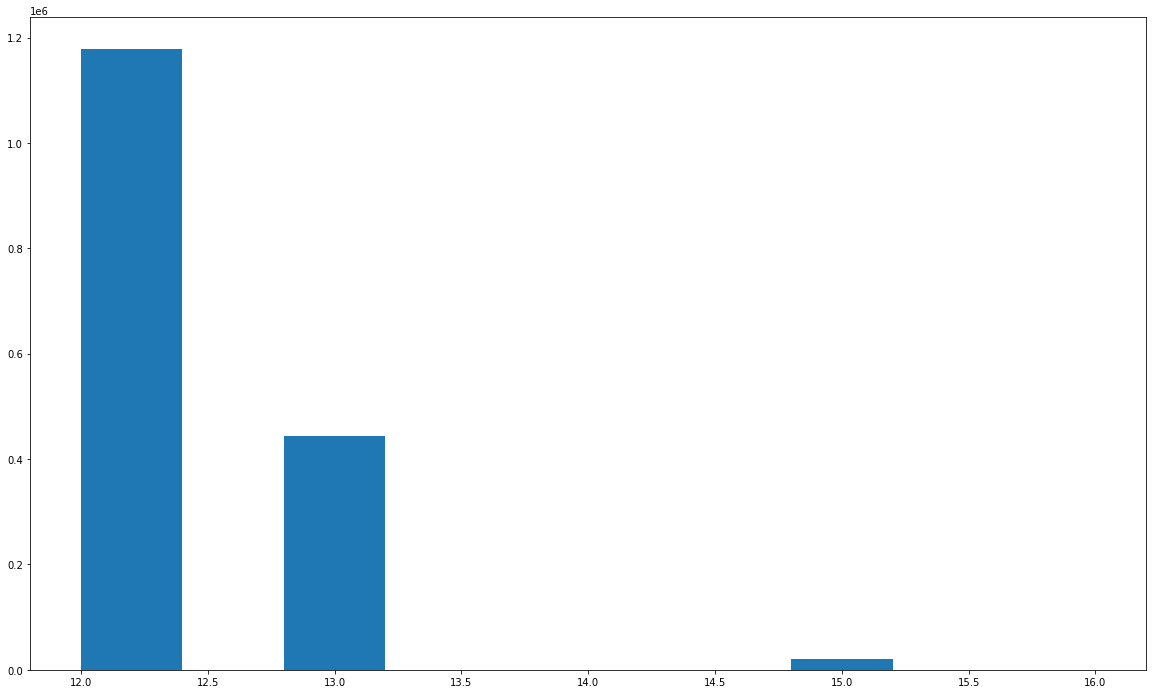

In [12]:
plt.hist(np.asarray(dataset["data"][1]).flatten())
plt.show()

### Saving the model

Having trained the model, it can now be saved in the `submission` folder so that it may be evaluated on [DOXA](https://climatehack.ai/compete).

## Submitting your model to DOXA

Well done -- you made it to the end!

You are now ready to submit your model to DOXA!

If you are not already logged in, run the following command:

```bash
$ python doxa_cli.py user login
```

Finally, to submit your model, upload the entire `submission` folder into which your model was saved using the following command:

```bash
$ python doxa_cli.py agent upload climatehack ./submission
```